In [1]:
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from skimage.io import imread

from skimage.color import rgb2gray, rgba2rgb  # Import rgba2rgb to handle 4-channel images

from skimage.feature import hog

from tqdm import tqdm

from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier






In [2]:
# Directory of the Mango Fruit dataset

data_dir = '/kaggle/input/mangofruitdds/MangoFruitDDS/SenMangoFruitDDS_bgremoved'  # You can switch to _original if needed

print(os.listdir(data_dir))



# Get class names from the directory structure

class_names = os.listdir(data_dir)



# Prepare a list to store filenames and labels

data = []



# Iterate through each class folder to collect filenames and their labels

for class_name in class_names:

    class_dir = os.path.join(data_dir, class_name)

    if os.path.isdir(class_dir):  # Check if it is a directory

        for filename in os.listdir(class_dir):

            if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust file extensions if necessary

                data.append((os.path.join(class_name, filename), class_name))



# Create a DataFrame

df = pd.DataFrame(data, columns=['filename', 'label'])



# Show the first few rows of the DataFrame

print(df.head())


['Anthracnose', 'Alternaria', 'Healthy', 'Stem and Rot', 'Black Mould Rot']
                          filename        label
0  Anthracnose/Anthracnose_002.jpg  Anthracnose
1  Anthracnose/Anthracnose_066.jpg  Anthracnose
2  Anthracnose/Anthracnose_057.jpg  Anthracnose
3  Anthracnose/Anthracnose_096.jpg  Anthracnose
4  Anthracnose/Anthracnose_106.jpg  Anthracnose


In [3]:
# Split the data into training and temp (validation + test)

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])  # 70% train, 30% temp



# Split temp into validation and test

validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])  # 15% val, 15% test



# Print out the sizes of the splits

print(f"Training samples: {len(train_df)}, Validation samples: {len(validation_df)}, Testing samples: {len(test_df)}")


Training samples: 586, Validation samples: 126, Testing samples: 126


In [4]:
# Create ImageDataGenerators for train, validation, and test

train_datagen = ImageDataGenerator(rescale=1./255, 

                                   rotation_range=30,

                                   horizontal_flip=True,

                                   vertical_flip=True,

                                   fill_mode='nearest')  # Data augmentation for training



val_test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalization for validation and test



# Generators for training

train_generator = train_datagen.flow_from_dataframe(

    train_df,

    directory=data_dir,

    x_col='filename',

    y_col='label',

    target_size=(224, 224),

    batch_size=32,

    class_mode='categorical',

    shuffle=True

)



# Generators for validation

validation_generator = val_test_datagen.flow_from_dataframe(

    validation_df,

    directory=data_dir,

    x_col='filename',

    y_col='label',

    target_size=(224, 224),

    batch_size=32,

    class_mode='categorical',

    shuffle=False

)



# Generators for testing

test_generator = val_test_datagen.flow_from_dataframe(

    test_df,

    directory=data_dir,

    x_col='filename',

    y_col='label',

    target_size=(224, 224),

    batch_size=32,

    class_mode='categorical',

    shuffle=False

)


Found 586 validated image filenames belonging to 5 classes.
Found 126 validated image filenames belonging to 5 classes.
Found 126 validated image filenames belonging to 5 classes.


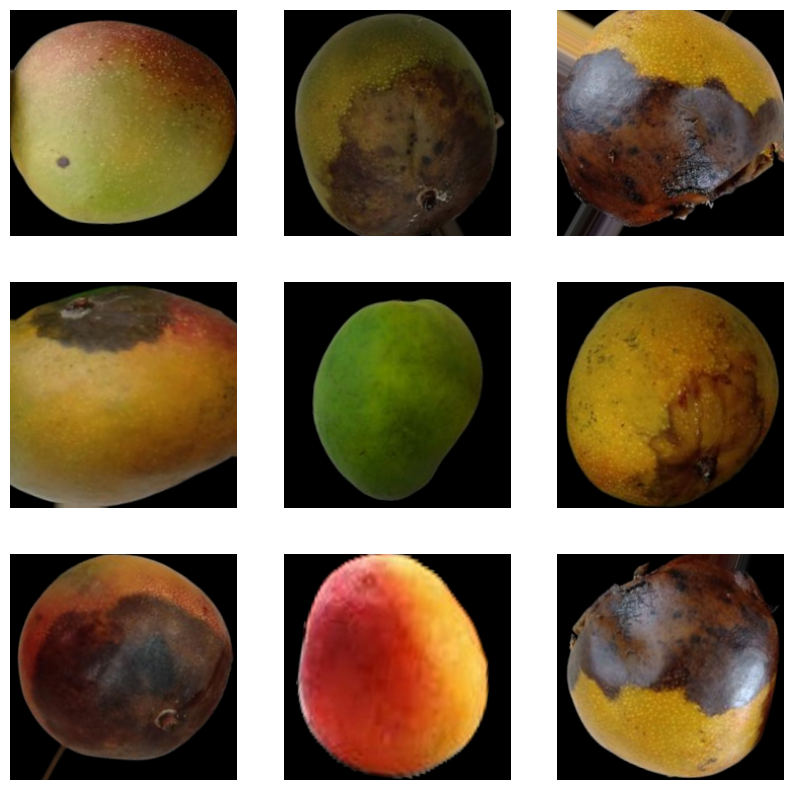

In [5]:
# Visualize a batch of images

sample_batch = next(train_generator)  # Get one batch of training images

plt.figure(figsize=(10, 10))

for i in range(9):  # Display 9 images from the batch

    plt.subplot(3, 3, i+1)

    plt.imshow(sample_batch[0][i])

    plt.axis('off')

plt.show()


In [6]:
# Function to extract HOG features from an image path

def extract_hog_features(image_path):

    image = imread(image_path)

    

    # If the image has 4 channels (RGBA), convert it to RGB

    if image.shape[-1] == 4:

        image = rgba2rgb(image)

    

    # Convert the image to grayscale

    image_gray = rgb2gray(image)

    

    # Extract HOG features

    features = hog(image_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)

    return features



# Function to extract HOG features and pad/truncate to a fixed length

def extract_and_pad_hog_features(image_filenames):

    hog_features = []

    max_length = 2916  # HOG features length for 224x224 image with (16, 16) pixels_per_cell

    

    for f in tqdm(image_filenames):

        features = extract_hog_features(os.path.join(data_dir, f))

        

        # Padding or truncating to ensure all feature vectors have the same length

        if len(features) < max_length:

            features = np.pad(features, (0, max_length - len(features)), 'constant')

        elif len(features) > max_length:

            features = features[:max_length]

        

        hog_features.append(features)

    

    return np.array(hog_features)

In [7]:
# Extract HOG features for training, validation, and testing datasets

train_features = extract_and_pad_hog_features(train_df['filename'])

validation_features = extract_and_pad_hog_features(validation_df['filename'])

test_features = extract_and_pad_hog_features(test_df['filename'])


100%|██████████| 126/126 [00:02<00:00, 60.07it/s]


In [8]:
# Convert labels into numerical form

label_encoder = LabelEncoder()

train_labels = label_encoder.fit_transform(train_df['label'])

validation_labels = label_encoder.transform(validation_df['label'])

test_labels = label_encoder.transform(test_df['label'])


In [9]:
# Function to train a model and evaluate it on validation data

def train_and_evaluate(model, train_features, train_labels, validation_features, validation_labels):

    # Train the model

    model.fit(train_features, train_labels)

    

    # Make predictions on validation data

    validation_preds = model.predict(validation_features)

    

    # Calculate evaluation metrics

    accuracy = accuracy_score(validation_labels, validation_preds)

    precision = precision_score(validation_labels, validation_preds, average='weighted')

    recall = recall_score(validation_labels, validation_preds, average='weighted')

    f1 = f1_score(validation_labels, validation_preds, average='weighted')

    

    # Return the metrics as a tuple

    return accuracy, precision, recall, f1

In [10]:
# Train Naive Bayes classifier on HOG features

nb_classifier = GaussianNB()

nb_classifier.fit(train_features, train_labels)



# Evaluate Naive Bayes using the train_and_evaluate function

nb_metrics = train_and_evaluate(nb_classifier, train_features, train_labels, validation_features, validation_labels)



# Display Naive Bayes results

print("Naive Bayes Metrics: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*nb_metrics))


Naive Bayes Metrics: Accuracy: 0.47, Precision: 0.50, Recall: 0.47, F1-Score: 0.47


In [11]:
# 1. SVM Model

svm_model = SVC(kernel='linear', random_state=42)



# Evaluate SVM using the train_and_evaluate function

svm_metrics = train_and_evaluate(svm_model, train_features, train_labels, validation_features, validation_labels)



# Display SVM results

print("SVM Metrics: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*svm_metrics))


SVM Metrics: Accuracy: 0.45, Precision: 0.48, Recall: 0.45, F1-Score: 0.46


In [12]:
# 2. Random Forest Model

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)



# Evaluate Random Forest using the train_and_evaluate function

rf_metrics = train_and_evaluate(rf_model, train_features, train_labels, validation_features, validation_labels)



# Display Random Forest results

print("Random Forest Metrics: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*rf_metrics))


Random Forest Metrics: Accuracy: 0.51, Precision: 0.54, Recall: 0.51, F1-Score: 0.52


In [13]:
# 3. K-Nearest Neighbors Model

knn_model = KNeighborsClassifier(n_neighbors=5)



# Evaluate KNN using the train_and_evaluate function

knn_metrics = train_and_evaluate(knn_model, train_features, train_labels, validation_features, validation_labels)



# Display KNN results

print("KNN Metrics: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*knn_metrics))


KNN Metrics: Accuracy: 0.52, Precision: 0.57, Recall: 0.52, F1-Score: 0.53


In [14]:
# Import the DecisionTreeClassifier from sklearn.tree

from sklearn.tree import DecisionTreeClassifier



# 4. Decision Tree Model

dt_model = DecisionTreeClassifier(random_state=42)



# Evaluate Decision Tree using the train_and_evaluate function

dt_metrics = train_and_evaluate(dt_model, train_features, train_labels, validation_features, validation_labels)



# Display Decision Tree results

print("Decision Tree Metrics: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*dt_metrics))


Decision Tree Metrics: Accuracy: 0.43, Precision: 0.43, Recall: 0.43, F1-Score: 0.43


In [15]:
# Summarize and compare metrics of different models

models = ['Naive Bayes', 'SVM', 'Random Forest', 'KNN', 'Decision Tree'] 

metrics = [nb_metrics, svm_metrics, rf_metrics, knn_metrics, dt_metrics] 



# Display a comparison table

for i, model_name in enumerate(models):

    print(f"{model_name} Metrics: Accuracy: {metrics[i][0]:.2f}, Precision: {metrics[i][1]:.2f}, Recall: {metrics[i][2]:.2f}, F1-Score: {metrics[i][3]:.2f}")


Naive Bayes Metrics: Accuracy: 0.47, Precision: 0.50, Recall: 0.47, F1-Score: 0.47
SVM Metrics: Accuracy: 0.45, Precision: 0.48, Recall: 0.45, F1-Score: 0.46
Random Forest Metrics: Accuracy: 0.51, Precision: 0.54, Recall: 0.51, F1-Score: 0.52
KNN Metrics: Accuracy: 0.52, Precision: 0.57, Recall: 0.52, F1-Score: 0.53
Decision Tree Metrics: Accuracy: 0.43, Precision: 0.43, Recall: 0.43, F1-Score: 0.43


In [16]:
import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt


In [17]:
from tensorflow.keras import Input



# Define CNN model architecture

def create_basic_cnn(input_shape=(224, 224, 3), num_classes=len(train_generator.class_indices)):

    model = Sequential([

        Input(shape=input_shape),  # Define input shape using Input layer

        Conv2D(32, (3, 3), activation='relu'),

        MaxPooling2D((2, 2)),

        

        Conv2D(64, (3, 3), activation='relu'),

        MaxPooling2D((2, 2)),

        

        Conv2D(128, (3, 3), activation='relu'),

        MaxPooling2D((2, 2)),

        

        Flatten(),

        Dense(128, activation='relu'),

        Dropout(0.5),

        Dense(num_classes, activation='softmax')

    ])

    

    model.compile(optimizer='adam', 

                  loss='categorical_crossentropy', 

                  metrics=['accuracy'])

    

    return model



# Initialize the CNN model

cnn_model = create_basic_cnn()


In [18]:
# Early stopping to prevent overfitting

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



# Train the model

history = cnn_model.fit(

    train_generator,

    epochs=20,  # Adjust epochs as necessary

    validation_data=validation_generator,

    callbacks=[early_stopping],

    verbose = True

)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732288727.648312      74 service.cc:145] XLA service 0x7c9b2c0066d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732288727.648389      74 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/19 ━━━━━━━━━━━━━━━━━━━━ 2:57 10s/step - accuracy: 0.1875 - loss: 1.6236

I0000 00:00:1732288732.950743      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 480ms/step - accuracy: 0.2594 - loss: 1.9120 - val_accuracy: 0.4841 - val_loss: 1.2128
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.4943 - loss: 1.2009 - val_accuracy: 0.5159 - val_loss: 1.1350
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - accuracy: 0.5712 - loss: 1.0857 - val_accuracy: 0.5476 - val_loss: 1.0686
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step - accuracy: 0.5555 - loss: 1.0829 - val_accuracy: 0.6190 - val_loss: 1.0197
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 266ms/step - accuracy: 0.6219 - loss: 0.9583 - val_accuracy: 0.6270 - val_loss: 0.8988
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.6332 - loss: 0.9082 - val_accuracy: 0.6032 - val_loss: 0.9336
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - accuracy: 0.6529 - loss: 0.8927 - val_accuracy: 0.6349 - val_loss: 0.8856
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.6571 - loss: 0.8432 - val_accuracy: 0.5952 - val

In [19]:
# Evaluate on the test dataset

test_loss, test_accuracy = cnn_model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy:.2f}")



# Generate predictions

y_pred = cnn_model.predict(test_generator)

y_pred_labels = y_pred.argmax(axis=1)



# Get true labels from the test set

true_labels = test_generator.classes


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7597 - loss: 0.6522
Test Accuracy: 0.72
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


In [20]:
# Performance metrics

test_precision = precision_score(true_labels, y_pred_labels, average='macro')

test_recall = recall_score(true_labels, y_pred_labels, average='macro')

test_f1 = f1_score(true_labels, y_pred_labels, average='macro')



# Print classification report and metrics

print("Classification Report:\n", classification_report(true_labels, y_pred_labels, target_names=test_generator.class_indices.keys()))

print(f"Test Precision: {test_precision:.2f}")

print(f"Test Recall: {test_recall:.2f}")

print(f"Test F1-Score: {test_f1:.2f}")


Classification Report:
                  precision    recall  f1-score   support

     Alternaria       0.64      0.36      0.46        25
    Anthracnose       0.87      0.68      0.76        19
Black Mould Rot       0.54      0.75      0.63        28
        Healthy       0.80      0.90      0.85        31
   Stem and Rot       0.87      0.87      0.87        23

       accuracy                           0.72       126
      macro avg       0.74      0.71      0.71       126
   weighted avg       0.73      0.72      0.71       126

Test Precision: 0.74
Test Recall: 0.71
Test F1-Score: 0.71


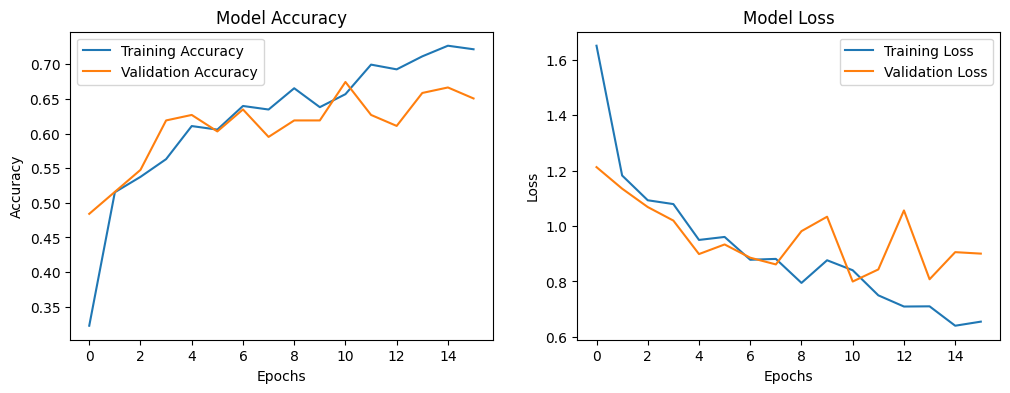

In [21]:
# Plotting training history (accuracy & loss)

plt.figure(figsize=(12, 4))



# Plot training & validation accuracy

plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.legend()



# Plot training & validation loss

plt.subplot(1, 2, 2)

plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend()



plt.show()


In [22]:
# Save the trained model to a file

cnn_model.save('fruit_disease_cnn.h5')  # Save as a .h5 file


In [23]:
# Load the saved CNN model

loaded_model = tf.keras.models.load_model('fruit_disease_cnn.h5')


In [24]:
import os



# List all files in the working directory

files = os.listdir('/kaggle/working')

print("Files in working directory:", files)


Files in working directory: ['__notebook__.ipynb', 'fruit_disease_cnn.h5']


In [25]:
import os

import numpy as np

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout



# Define paths for both dataset folders

base_dir = '/kaggle/input/mangofruitdds/MangoFruitDDS'

bg_dir = os.path.join(base_dir, 'SenMangoFruitDDS_bgremoved')  # Images with background

no_bg_dir = os.path.join(base_dir, 'SenMangoFruitDDS_original')  # Images without background



# Define image size and batch size

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 32



# Create ImageDataGenerators for both datasets

datagen = ImageDataGenerator(rescale=1./255, 

                             validation_split=0.2, 

                             rotation_range=20, 

                             zoom_range=0.2, 

                             horizontal_flip=True)



# Load background images

bg_train_generator = datagen.flow_from_directory(

    bg_dir,

    target_size=IMAGE_SIZE,

    batch_size=BATCH_SIZE,

    class_mode='categorical',

    subset='training',

    shuffle=True

)



bg_val_generator = datagen.flow_from_directory(

    bg_dir,

    target_size=IMAGE_SIZE,

    batch_size=BATCH_SIZE,

    class_mode='categorical',

    subset='validation',

    shuffle=True

)



# Load background-removed images

no_bg_train_generator = datagen.flow_from_directory(

    no_bg_dir,

    target_size=IMAGE_SIZE,

    batch_size=BATCH_SIZE,

    class_mode='categorical',

    subset='training',

    shuffle=True

)



no_bg_val_generator = datagen.flow_from_directory(

    no_bg_dir,

    target_size=IMAGE_SIZE,

    batch_size=BATCH_SIZE,

    class_mode='categorical',

    subset='validation',

    shuffle=True

)



# Combine the background and background-removed datasets

def combine_generators(gen1, gen2):

    while True:

        x1, y1 = next(gen1)

        x2, y2 = next(gen2)

        yield np.concatenate((x1, x2)), np.concatenate((y1, y2))



train_generator = combine_generators(bg_train_generator, no_bg_train_generator)

validation_generator = combine_generators(bg_val_generator, no_bg_val_generator)



# Define a simple CNN model

def create_basic_cnn(input_shape=(224, 224, 3), num_classes=3):

    model = Sequential([

        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),

        MaxPooling2D((2, 2)),

        

        Conv2D(64, (3, 3), activation='relu'),

        MaxPooling2D((2, 2)),

        

        Conv2D(128, (3, 3), activation='relu'),

        MaxPooling2D((2, 2)),

        

        Flatten(),

        Dense(128, activation='relu'),

        Dropout(0.5),

        Dense(num_classes, activation='softmax')

    ])

    

    model.compile(optimizer='adam', 

                  loss='categorical_crossentropy', 

                  metrics=['accuracy'])

    

    return model



# Initialize the CNN model for leaf disease

cnn_model = create_basic_cnn(num_classes=len(bg_train_generator.class_indices))



# Add an early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



# Define a custom callback for verbose logging

class VerboseLogging(tf.keras.callbacks.Callback):

    def on_train_batch_end(self, batch, logs=None):

        print(f"Training - Batch {batch + 1}: Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")



    def on_val_batch_end(self, batch, logs=None):

        print(f"Validation - Batch {batch + 1}: Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")



# Calculate steps per epoch and validation steps

train_steps = min(bg_train_generator.samples // BATCH_SIZE, no_bg_train_generator.samples // BATCH_SIZE)

val_steps = min(bg_val_generator.samples // BATCH_SIZE, no_bg_val_generator.samples // BATCH_SIZE)



# Train the model

history = cnn_model.fit(

    train_generator,

    steps_per_epoch=train_steps,  # Updated to ensure no repetitions

    validation_data=validation_generator,

    validation_steps=val_steps,  # Updated to ensure no repetitions

    epochs=20,

    callbacks=[early_stopping, VerboseLogging()]

)



# Evaluate the model

test_loss, test_accuracy = cnn_model.evaluate(validation_generator, steps=val_steps)

print(f"Test Accuracy: {test_accuracy:.2f}")


Found 672 images belonging to 5 classes.
Found 166 images belonging to 5 classes.
Found 691 images belonging to 5 classes.
Found 171 images belonging to 5 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
Training - Batch 1: Loss: 1.6100, Accuracy: 0.1875
 1/21 ━━━━━━━━━━━━━━━━━━━━ 2:23 7s/step - accuracy: 0.1875 - loss: 1.6100Training - Batch 2: Loss: 2.0555, Accuracy: 0.2109
 2/21 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1992 - loss: 1.8328Training - Batch 3: Loss: 2.0417, Accuracy: 0.2240
 3/21 ━━━━━━━━━━━━━━━━━━━━ 8s 462ms/step - accuracy: 0.2075 - loss: 1.9024Training - Batch 4: Loss: 1.9283, Accuracy: 0.2344
 4/21 ━━━━━━━━━━━━━━━━━━━━ 10s 592ms/step - accuracy: 0.2142 - loss: 1.9089Training - Batch 5: Loss: 1.8578, Accuracy: 0.2438
 5/21 ━━━━━━━━━━━━━━━━━━━━ 10s 660ms/step - accuracy: 0.2201 - loss: 1.8987Training - Batch 6: Loss: 1.8128, Accuracy: 0.2344
 6/21 ━━━━━━━━━━━━━━━━━━━━ 10s 688ms/step - accuracy: 0.2225 - loss: 1.8844Training - Batch 7: Loss: 1.7760, Accuracy: 0.2433
 7/21 ━━━━━━━━━━━━━━━━━━━━ 9s 709ms/step - accuracy: 0.2255 - loss: 1.8689 Training - Batch 8: Loss: 1.7427, Accuracy: 0.2520
 8/21 ━━━━━━━━━━━━━━━━━━━━ 9s 726ms/step - accuracy: 0.2288 -

In [26]:
# Reset generators before evaluation

bg_val_generator.reset()

no_bg_val_generator.reset()



# Collect true labels and predicted labels

y_true = []

y_pred = []



# Iterate through the validation steps

for _ in range(val_steps):

    # Get batch from background and background-removed data

    x_bg, y_bg_true = next(bg_val_generator)

    x_no_bg, y_no_bg_true = next(no_bg_val_generator)

    

    # Concatenate batches

    x_combined = np.concatenate((x_bg, x_no_bg))

    y_combined_true = np.concatenate((y_bg_true, y_no_bg_true))

    

    # Append true labels

    y_true.extend(np.argmax(y_combined_true, axis=1))

    

    # Predict using the trained model

    y_pred_prob = cnn_model.predict(x_combined)

    y_pred.extend(np.argmax(y_pred_prob, axis=1))



# Convert lists to numpy arrays

y_true = np.array(y_true)

y_pred = np.array(y_pred)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [27]:
from sklearn.metrics import classification_report



# Generate the classification report

report = classification_report(y_true, y_pred, target_names=bg_val_generator.class_indices.keys())

print(report)


                 precision    recall  f1-score   support

     Alternaria       0.63      0.47      0.54        62
    Anthracnose       0.83      0.80      0.82        50
Black Mould Rot       0.54      0.68      0.60        72
        Healthy       0.95      0.93      0.94        76
   Stem and Rot       0.87      0.87      0.87        60

       accuracy                           0.75       320
      macro avg       0.76      0.75      0.75       320
   weighted avg       0.76      0.75      0.75       320



In [28]:
# Evaluate on the test dataset

test_loss, test_accuracy = cnn_model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy:.2f}")



# Generate predictions

y_pred = cnn_model.predict(test_generator)

y_pred_labels = y_pred.argmax(axis=1)



# Get true labels from the test set

true_labels = test_generator.classes


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.7934 - loss: 0.4206
Test Accuracy: 0.78
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


In [29]:
# Performance metrics

test_precision = precision_score(true_labels, y_pred_labels, average='macro')

test_recall = recall_score(true_labels, y_pred_labels, average='macro')

test_f1 = f1_score(true_labels, y_pred_labels, average='macro')



# Print classification report and metrics

print("Classification Report:\n", classification_report(true_labels, y_pred_labels, target_names=test_generator.class_indices.keys()))

print(f"Test Precision: {test_precision:.2f}")

print(f"Test Recall: {test_recall:.2f}")

print(f"Test F1-Score: {test_f1:.2f}")


Classification Report:
                  precision    recall  f1-score   support

     Alternaria       0.74      0.56      0.64        25
    Anthracnose       0.82      0.74      0.78        19
Black Mould Rot       0.57      0.71      0.63        28
        Healthy       0.94      0.97      0.95        31
   Stem and Rot       0.87      0.87      0.87        23

       accuracy                           0.78       126
      macro avg       0.79      0.77      0.77       126
   weighted avg       0.79      0.78      0.78       126

Test Precision: 0.79
Test Recall: 0.77
Test F1-Score: 0.77


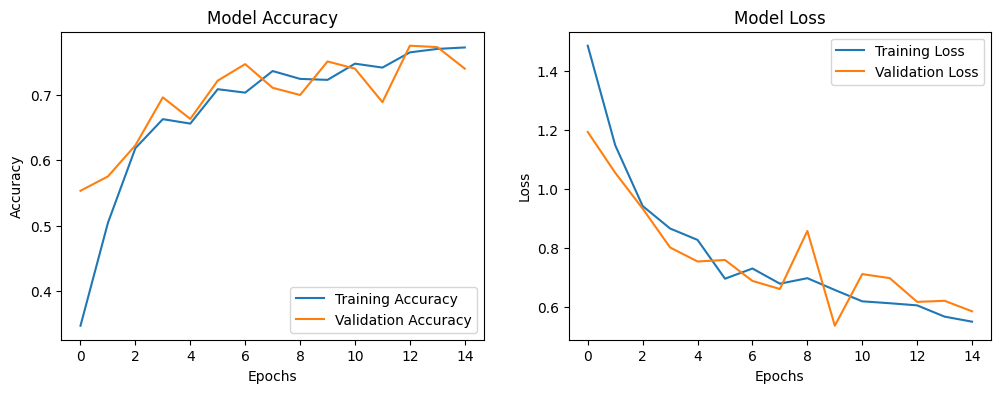

In [30]:
# Plotting training history (accuracy & loss)

plt.figure(figsize=(12, 4))



# Plot training & validation accuracy

plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.legend()



# Plot training & validation loss

plt.subplot(1, 2, 2)

plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend()



plt.show()


In [31]:
# Save the trained model to a file

cnn_model.save('fruit_disease_cnn.h5')  # Save as a .h5 file


## ResNet

Found 672 images belonging to 5 classes.
Found 166 images belonging to 5 classes.
Found 691 images belonging to 5 classes.
Found 171 images belonging to 5 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5114 - loss: 1.2978 - val_accuracy: 0.7781 - val_loss: 0.5686
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 899ms/step - accuracy: 0.7930 - loss: 0.5647 - val_accuracy: 0.8022 - val_loss: 0.5467
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 732ms/step - accuracy: 0.8268 - loss: 0.4569 - val_accuracy: 0.8828 - val_loss: 0.4059
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 788ms/step - accuracy: 0.8570 - loss: 0.3654 - val_accuracy: 0.8571 - val_loss: 0.4122
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 806ms/step - accuracy: 0.8701 - loss: 0.3748 - val_accuracy: 0.8315 - val_loss: 0.4456
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 779ms/step - accuracy: 0.8857 - loss: 0.3056 - val_accuracy: 0.8828 - val_loss: 0.3839
Epoch 7/20
21/

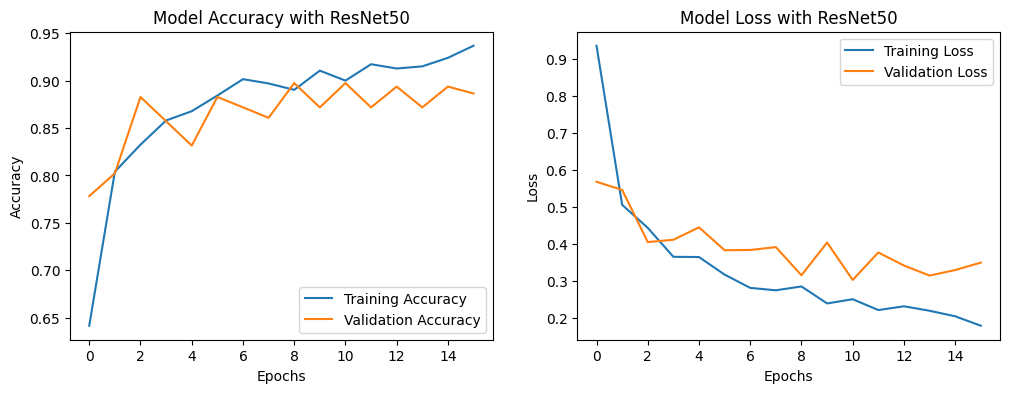

In [32]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define paths for both dataset folders
base_dir = '/kaggle/input/mangofruitdds/MangoFruitDDS'
bg_dir = os.path.join(base_dir, 'SenMangoFruitDDS_bgremoved')  # Images with background
no_bg_dir = os.path.join(base_dir, 'SenMangoFruitDDS_original')  # Images without background

# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Create ImageDataGenerators for both datasets
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Use ResNet50 preprocessing
    validation_split=0.2, 
    rotation_range=20, 
    zoom_range=0.2, 
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # Only rescaling for test data
)

# Load background images
bg_train_generator = train_datagen.flow_from_directory(
    bg_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

bg_val_generator = train_datagen.flow_from_directory(
    bg_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Load background-removed images
no_bg_train_generator = train_datagen.flow_from_directory(
    no_bg_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

no_bg_val_generator = train_datagen.flow_from_directory(
    no_bg_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Combine the background and background-removed datasets
def combine_generators(gen1, gen2):
    while True:
        x1, y1 = next(gen1)
        x2, y2 = next(gen2)
        yield np.concatenate((x1, x2)), np.concatenate((y1, y2))

train_generator = combine_generators(bg_train_generator, no_bg_train_generator)
validation_generator = combine_generators(bg_val_generator, no_bg_val_generator)

# Define the ResNet50 model for transfer learning
def create_resnet_model(input_shape=(224, 224, 3), num_classes=3):
    # Load the ResNet50 model with pre-trained ImageNet weights, excluding the top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model layers to prevent them from training
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Replace Flatten with GlobalAveragePooling
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Get the number of classes
num_classes = len(bg_train_generator.class_indices)

# Initialize the ResNet50 model
resnet_model = create_resnet_model(num_classes=num_classes)

# Add an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Calculate steps per epoch and validation steps
train_steps = min(bg_train_generator.samples // BATCH_SIZE, no_bg_train_generator.samples // BATCH_SIZE)
val_steps = min(bg_val_generator.samples // BATCH_SIZE, no_bg_val_generator.samples // BATCH_SIZE)

# Train the model
history = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=20,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = resnet_model.evaluate(validation_generator, steps=val_steps)
print(f"Validation Accuracy: {test_accuracy:.2f}")

# Reset generators before evaluation
bg_val_generator.reset()
no_bg_val_generator.reset()

# Collect true labels and predicted labels
y_true = []
y_pred = []

# Iterate through the validation steps
for _ in range(val_steps):
    # Get batch from background and background-removed data
    x_bg, y_bg_true = next(bg_val_generator)
    x_no_bg, y_no_bg_true = next(no_bg_val_generator)
    
    # Concatenate batches
    x_combined = np.concatenate((x_bg, x_no_bg))
    y_combined_true = np.concatenate((y_bg_true, y_no_bg_true))
    
    # Append true labels
    y_true.extend(np.argmax(y_combined_true, axis=1))
    
    # Predict using the trained model
    y_pred_prob = resnet_model.predict(x_combined)
    y_pred.extend(np.argmax(y_pred_prob, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=bg_val_generator.class_indices.keys())
print("Classification Report:\n", report)

# Assuming you have a separate test dataset generator
# If you don't have a separate test generator, you can skip this part
# test_generator = ...

# Evaluate on the test dataset (if available)
# test_loss, test_accuracy = resnet_model.evaluate(test_generator)
# print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate predictions (if test_generator is available)
# y_pred = resnet_model.predict(test_generator)
# y_pred_labels = y_pred.argmax(axis=1)

# Get true labels from the test set
# true_labels = test_generator.classes

# Performance metrics (if test_generator is available)
# test_precision = precision_score(true_labels, y_pred_labels, average='macro')
# test_recall = recall_score(true_labels, y_pred_labels, average='macro')
# test_f1 = f1_score(true_labels, y_pred_labels, average='macro')

# Print classification report and metrics (if test_generator is available)
# print("Test Classification Report:\n", classification_report(true_labels, y_pred_labels, target_names=test_generator.class_indices.keys()))
# print(f"Test Precision: {test_precision:.2f}")
# print(f"Test Recall: {test_recall:.2f}")
# print(f"Test F1-Score: {test_f1:.2f}")

# Plotting training history (accuracy & loss)
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with ResNet50')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with ResNet50')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the trained model to a file
resnet_model.save('fruit_disease_resnet.h5')  # Save as a .h5 file


## Efficient Net

Found 672 images belonging to 5 classes.
Found 166 images belonging to 5 classes.
Found 691 images belonging to 5 classes.
Found 171 images belonging to 5 classes.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.4989 - loss: 1.2295 - val_accuracy: 0.7844 - val_loss: 0.6709
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.7156 - loss: 0.7074 - val_accuracy: 0.7509 - val_loss: 0.5881
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7723 - loss: 0.5793 - val_accuracy: 0.8242 - val_loss: 0.5134
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8030 - loss: 0.5080 - val_accuracy: 0.8132 - val_loss: 0.5258
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7876 - loss: 0.5259 - val_accuracy: 0.8132 - val_loss: 0.5347
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8018 - loss: 0.5132 - val_accuracy: 0.8535 - val_loss: 0.4225
Epoch 7/20
21/21 ━━━━━━━━━━━━

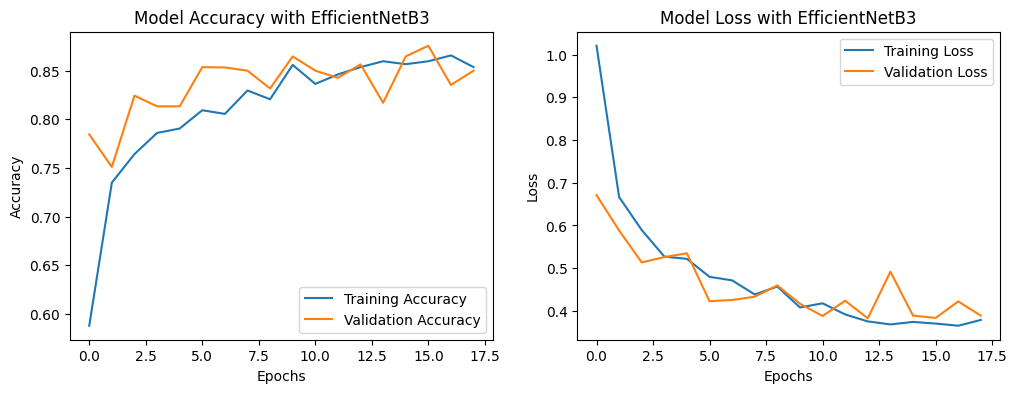

In [33]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Define paths for both dataset folders
base_dir = '/kaggle/input/mangofruitdds/MangoFruitDDS'
bg_dir = os.path.join(base_dir, 'SenMangoFruitDDS_bgremoved')  # Images with background
no_bg_dir = os.path.join(base_dir, 'SenMangoFruitDDS_original')  # Images without background

# Define image size and batch size
IMAGE_SIZE = (300, 300)  # EfficientNetB3 input size
BATCH_SIZE = 32

# Create ImageDataGenerators for both datasets
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,  # EfficientNet preprocessing
    validation_split=0.2, 
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

# Load background images
bg_train_generator = train_datagen.flow_from_directory(
    bg_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

bg_val_generator = validation_datagen.flow_from_directory(
    bg_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Load background-removed images
no_bg_train_generator = train_datagen.flow_from_directory(
    no_bg_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

no_bg_val_generator = validation_datagen.flow_from_directory(
    no_bg_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Combine the background and background-removed datasets
def combine_generators(gen1, gen2):
    while True:
        x1, y1 = next(gen1)
        x2, y2 = next(gen2)
        yield np.concatenate((x1, x2)), np.concatenate((y1, y2))

train_generator = combine_generators(bg_train_generator, no_bg_train_generator)
validation_generator = combine_generators(bg_val_generator, no_bg_val_generator)

# Define the EfficientNetB3 model for transfer learning
def create_efficientnet_model(input_shape=(300, 300, 3), num_classes=3):
    # Load the EfficientNetB3 model with pre-trained ImageNet weights, excluding the top layers
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Get the number of classes
num_classes = len(bg_train_generator.class_indices)

# Initialize the EfficientNetB3 model
efficientnet_model = create_efficientnet_model(num_classes=num_classes)

# Add an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Calculate steps per epoch and validation steps
train_steps = min(bg_train_generator.samples // BATCH_SIZE, no_bg_train_generator.samples // BATCH_SIZE)
val_steps = min(bg_val_generator.samples // BATCH_SIZE, no_bg_val_generator.samples // BATCH_SIZE)

# Train the model
history = efficientnet_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=20,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = efficientnet_model.evaluate(validation_generator, steps=val_steps)
print(f"Validation Accuracy: {test_accuracy:.2f}")

# Reset generators before evaluation
bg_val_generator.reset()
no_bg_val_generator.reset()

# Collect true labels and predicted labels
y_true = []
y_pred = []

# Iterate through the validation steps
for _ in range(val_steps):
    # Get batch from background and background-removed data
    x_bg, y_bg_true = next(bg_val_generator)
    x_no_bg, y_no_bg_true = next(no_bg_val_generator)
    
    # Concatenate batches
    x_combined = np.concatenate((x_bg, x_no_bg))
    y_combined_true = np.concatenate((y_bg_true, y_no_bg_true))
    
    # Append true labels
    y_true.extend(np.argmax(y_combined_true, axis=1))
    
    # Predict using the trained model
    y_pred_prob = efficientnet_model.predict(x_combined)
    y_pred.extend(np.argmax(y_pred_prob, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=bg_val_generator.class_indices.keys())
print("Classification Report:\n", report)

# Plotting training history (accuracy & loss)
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with EfficientNetB3')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss with EfficientNetB3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the trained model to a file
efficientnet_model.save('fruit_disease_efficientnetb3_finetuned.keras')
